In [2]:
import urllib.request
import zipfile
import os
from pathlib import Path

In [3]:
url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "ch06/sms_spam_collection.zip"
extracted_path = "ch06/sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"
print(data_file_path)

ch06/sms_spam_collection/SMSSpamCollection.tsv


In [4]:
def download_and_unzip_spam_data(
    url, zip_path, extracted_path, data_file_path
):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as fout:
            fout.write(response.read())

    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

In [5]:
download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

ch06/sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [6]:
import pandas as pd
df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [7]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


In [8]:
def create_balanced_dataset(df):
    spam_set = df[df["Label"] == "spam"]
    num_spam = spam_set.shape[0]
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)

    balanced_df = pd.concat([ham_subset, spam_set])
    return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [9]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

In [10]:
def random_split(df, train_frac, valid_frac):
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)
    train_end = int(len(df) * train_frac)
    valid_end = train_end + int(len(df) * valid_frac)

    train_df = df[:train_end]
    valid_df = df[train_end:valid_end]
    test_df = df[valid_end:]

    return train_df, valid_df, test_df

train_df, valid_df, test_df = random_split(balanced_df, 0.7, 0.1)

train_df.to_csv("ch06/train.csv", index=None)
valid_df.to_csv("ch06/valid.csv", index=None)
test_df.to_csv("ch06/test.csv", index=None)

In [11]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [12]:
# Setting up a Pytorch Dataset class

import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):

        self.data = pd.read_csv(csv_file)
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        if max_length is None:
            self.max_length = self._find_longest_encoded_length()
        else:
            self.max_length = max_length

            self.encoded_texts = [
                encoded_text[:max_length] for encoded_text in self.encoded_texts
            ]

        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text)) 
            for encoded_text in self.encoded_texts
        ]

    def _find_longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

    def __len__(self):
        return len(self.encoded_texts)

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]

        return torch.tensor(encoded).long(), torch.tensor(label).long()

In [13]:
train_dataset = SpamDataset("ch06/train.csv", tokenizer)
valid_dataset = SpamDataset("ch06/valid.csv", tokenizer, max_length=train_dataset.max_length)
test_dataset = SpamDataset("ch06/test.csv", tokenizer, max_length=train_dataset.max_length)


In [14]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 4
torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=num_workers, 
    drop_last=True)
valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    drop_last=False
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    drop_last=False
)

In [15]:
for input_data, target_data in train_loader:
    pass
print(input_data.shape, target_data.shape)

torch.Size([4, 120]) torch.Size([4])


In [16]:
print(len(train_loader), len(valid_loader), len(test_loader))

261 38 75


In [17]:
from codes.configs import build_gpt2_configs

BASE_CONFIG = build_gpt2_configs(
    "gpt2-small (124M)",
    {"context_length": 1024, "qkv_bias": True}
)

In [18]:
from codes.gpt_model import GPTModel

gpt = GPTModel(BASE_CONFIG).eval()

In [20]:
import tiktoken
from codes.utils import generate_text_simple, text_to_token_ids, token_ids_to_text

tokenizer = tiktoken.get_encoding("gpt2")

In [22]:
text_1 = "Every effort moves you"
token_ids = generate_text_simple(
    gpt,
    idx=text_to_token_ids(text_1, tokenizer=tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you241 Javascript Wolfgangurt Imp play Puerto His stretched571 deepening cancell hiking diet contamination


In [23]:
import torch
pretrained_state = torch.load("./gpt2-small-124m-pretrained.pth", map_location="cpu")
gpt.load_state_dict(pretrained_state)

<All keys matched successfully>

In [24]:
token_ids = generate_text_simple(
    gpt,
    idx=text_to_token_ids(text_1, tokenizer=tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


In [26]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no': "
    " 'You are a winner you have been specially selected to"
    " receive $1000 cash or a $2000 award.'"
)

token_ids = generate_text_simple(
    gpt,
    idx=text_to_token_ids(text_2, tokenizer=tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no':  'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

'You have been specially selected to receive $1000 cash or a $2000 award.' 'You have been


In [27]:
for param in gpt.parameters():
    param.requires_grad = False

In [28]:
torch.manual_seed(123)
num_classes = 2
gpt.out_head = torch.nn.Linear(BASE_CONFIG["emb_dim"], num_classes)

for param in gpt.trans_blocks[-1].parameters():
    param.requires_grad = True
for param in gpt.final_norm.parameters():
    param.requires_grad = True

In [29]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print(inputs.shape)

torch.Size([1, 4])


In [30]:
with torch.no_grad():
    logits = gpt(inputs)

print(logits.shape)

torch.Size([1, 4, 2])


In [31]:
print(logits[:,-1,:])

tensor([[-3.5983,  3.9902]])


In [35]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()

    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]
            predicted_labels = torch.argmax(logits, dim=-1)
            num_examples += predicted_labels.shape[0]

            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples
            

In [38]:
device = torch.device("cpu")
gpt = gpt.to(device)

torch.manual_seed(123)

In [39]:
train_accuracy = calc_accuracy_loader(train_loader, gpt, device, num_batches=10)
print(f"{train_accuracy:.2f}")

valid_accuracy = calc_accuracy_loader(valid_loader, gpt, device, num_batches=10)
print(f"{valid_accuracy:.2f}")

test_accuracy = calc_accuracy_loader(test_loader, gpt, device, num_batches=10)
print(f"{test_accuracy:.2f}")

0.40
0.50
0.55


In [40]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)

    logits = model(input_batch)[:,-1,:]
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

In [43]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0

    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches       

In [44]:
with torch.no_grad():
    train_loss = calc_loss_loader(
        train_loader, gpt, device, num_batches=5
    )
    val_loss = calc_loss_loader(
        valid_loader, gpt, device, num_batches=5
    )
    test_loss = calc_loss_loader(
        test_loader, gpt, device, num_batches=5
    )

print(f"Train loss: {train_loss:.2f}")
print(f"Valid loss: {val_loss:.2f}")
print(f"Test loss: {test_loss:.2f}")

Train loss: 2.07
Valid loss: 2.83
Test loss: 2.58


In [45]:
def evaluate_model(model, train_loader, valid_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        valid_loss = calc_loss_loader(valid_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, valid_loss

In [53]:
def train_classifier_simple(
    model,
    train_loader,
    valid_loader,
    optimizer,
    device,
    num_epochs,
    eval_freq,
    eval_iter
):
    train_losses, valid_losses, train_accs, valid_accs = [], [], [], []
    example_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(
                input_batch, 
                target_batch,
                model,
                device
            )

            loss.backward()
            optimizer.step()

            example_seen += input_batch.shape[0]
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, valid_loss = evaluate_model(model, train_loader, valid_loader, device, eval_iter)
                train_losses.append(train_loss)
                valid_losses.append(valid_loss)

                print(f"Ep {epoch + 1} (Step {global_step:06d}): "
                      f"Train loss: {train_loss:.3f} "
                      f"Val loss: {valid_loss:.3f}"
                )

        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        valid_accuracy = calc_accuracy_loader(valid_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}%")
        print(f"Validation accuracy: {valid_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        valid_accs.append(valid_accuracy)

    return train_losses, valid_losses, train_accs, valid_accs, example_seen
            

In [54]:
import time

start_time = time.time()
torch.manual_seed(123)
device = torch.device("mps")

gpt.to(device)
optimizer = torch.optim.AdamW(gpt.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 8

train_losses, valid_losses, train_accs, valid_accs, example_seen = train_classifier_simple(
    gpt,
    train_loader,
    valid_loader,
    optimizer,
    device,
    num_epochs,
    eval_freq=50,
    eval_iter=5
)
running_minutes = (time.time() - start_time) / 60
print(f"Training completed in {running_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss: 0.018 Val loss: 0.289
Ep 1 (Step 000050): Train loss: 0.230 Val loss: 0.276
Ep 1 (Step 000100): Train loss: 0.067 Val loss: 0.138
Ep 1 (Step 000150): Train loss: 0.021 Val loss: 0.046
Ep 1 (Step 000200): Train loss: 0.056 Val loss: 0.152
Ep 1 (Step 000250): Train loss: 0.020 Val loss: 0.113
Training accuracy: 95.00%
Validation accuracy: 90.00%
Ep 2 (Step 000300): Train loss: 0.010 Val loss: 0.016
Ep 2 (Step 000350): Train loss: 0.089 Val loss: 0.579
Ep 2 (Step 000400): Train loss: 0.013 Val loss: 0.093
Ep 2 (Step 000450): Train loss: 0.109 Val loss: 0.186
Ep 2 (Step 000500): Train loss: 0.050 Val loss: 0.107
Training accuracy: 85.00%
Validation accuracy: 90.00%
Ep 3 (Step 000550): Train loss: 0.004 Val loss: 0.021
Ep 3 (Step 000600): Train loss: 0.024 Val loss: 0.242
Ep 3 (Step 000650): Train loss: 0.038 Val loss: 0.131
Ep 3 (Step 000700): Train loss: 0.037 Val loss: 0.179
Ep 3 (Step 000750): Train loss: 0.028 Val loss: 0.142
Training accuracy: 100.00%
V

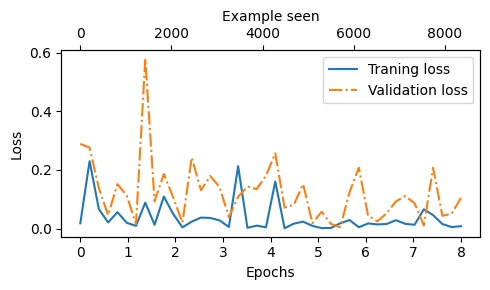

In [55]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, example_seen, train_value, valid_value, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    ax1.plot(epochs_seen, train_value, label=f"Traning {label}")
    ax1.plot(epochs_seen, valid_value, linestyle="-.", label=f"Validation {label}")

    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    ax2 = ax1.twiny()
    ax2.plot(example_seen, train_value, alpha=0)
    ax2.set_xlabel("Example seen")

    fig.tight_layout()
    plt.savefig(f"./ch06/{label}-plot.pdf")
    plt.show()
    
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
example_seen_tensor = torch.linspace(0, example_seen, len(train_losses))

plot_values(epochs_tensor, example_seen_tensor, train_losses, valid_losses, "loss")

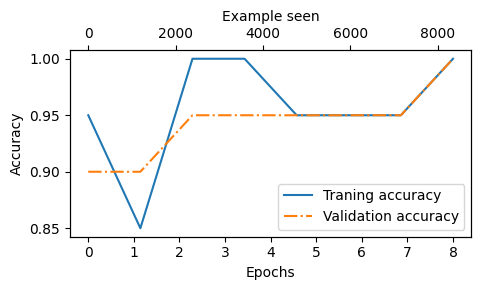

In [56]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
example_seen_tensor = torch.linspace(0, example_seen, len(train_accs))

plot_values(epochs_tensor, example_seen_tensor, train_accs, valid_accs, "accuracy")

In [57]:
train_accuracy = calc_accuracy_loader(train_loader, gpt, device)
valid_accuracy = calc_accuracy_loader(valid_loader, gpt, device)
test_accuracy = calc_accuracy_loader(test_loader, gpt, device)

print(f"{train_accuracy:.2f}")
print(f"{valid_accuracy:.2f}")
print(f"{test_accuracy:.2f}")

0.99
0.99
0.96


In [58]:
def classify_email(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[1]

    input_ids = input_ids[:min(supported_context_length, max_length)]
    input_ids = torch.tensor(input_ids).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(input_ids)[:,-1, :]
    predicted_label = torch.argmax(logits, dim=-1).item()

    return "spam" if predicted_label == 1 else "not spam"
    

In [59]:
text_1 = "You are a winner you have been specially selected to receive $1000 cash or $2000 award."
text_2 = "Hey, just wanted to check if we are still on for dinner tonight? Let me know!"

print(classify_email(text_1, gpt, tokenizer, device, train_dataset.max_length))
print(classify_email(text_2, gpt, tokenizer, device, train_dataset.max_length))

spam
not spam


In [60]:
torch.save(gpt.state_dict(), "./ch06/gpt2-small-124m-finetune-classifier.pth")